In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

seed=42

from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

import gc

np.random.seed(seed)

In [2]:
from gradcam import *

In [3]:
# garbage collection on learner
def reset_learner(data,is_fp16=False):
    learn=None
    gc.collect()
    learn = create_cnn(data, models.resnet50, metrics=accuracy)
    if is_fp16:
        learn = learn.to_fp16()
    return learn

# Final model

In [4]:
PATH = Path('data_draw')

In [5]:
data=None
gc.collect()

tfms = get_transforms()
data= ImageDataBunch.from_folder(PATH,train='train',valid='valid',test='both',bs=60,
                                 ds_tfms = tfms,size=350,num_workers=4).normalize(imagenet_stats)

learn= reset_learner(data)
learn.load('stage1-350-new-8epochs-303');

# From single Image object

In [6]:
test_img = PATH/'both/poca-mulan.jpg'
img = open_image(test_img);

In [7]:
type(img)

fastai.vision.image.Image

CPU times: user 1.27 s, sys: 670 ms, total: 1.94 s
Wall time: 3.17 s


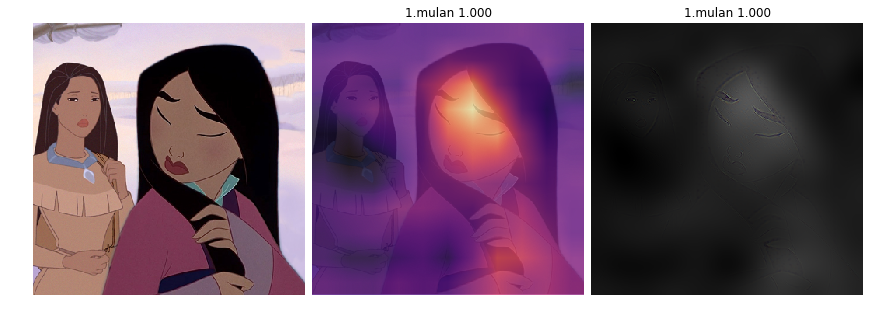

In [8]:
%%time
gcam = GradCam.from_one_img(learn,img)
gcam.plot()

CPU times: user 452 ms, sys: 23.5 ms, total: 476 ms
Wall time: 191 ms


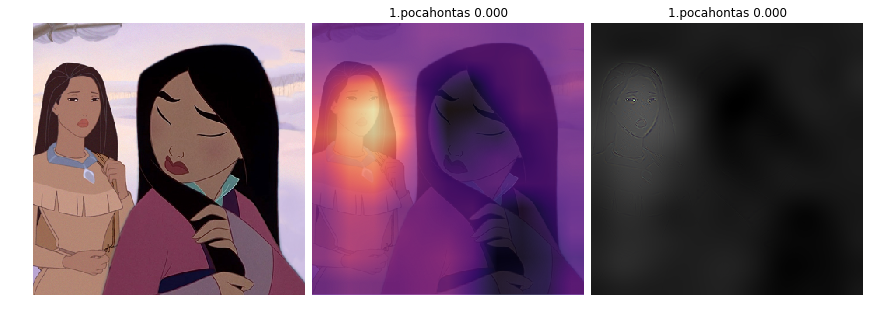

In [9]:
%%time
gcam = GradCam.from_one_img(learn,img,label1='pocahontas')
gcam.plot(plot_hm=True,plot_gbp=True)

## Plot 2 labels side-by-side (for model evaluation on different classes)

You can also choose to plot only heatmap or only guided backprop map

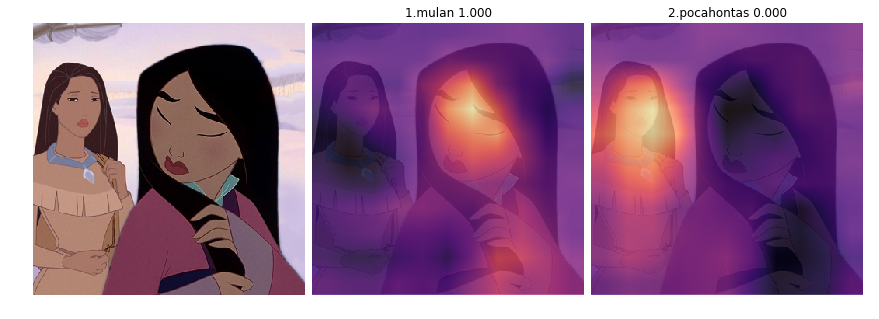

In [10]:
gcam = GradCam.from_one_img(learn,img,label2='pocahontas')
gcam.plot(plot_hm=True,plot_gbp=False)

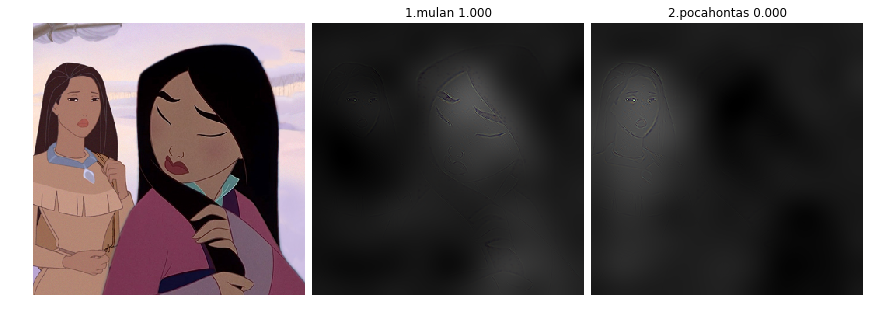

In [11]:
gcam = GradCam.from_one_img(learn,img,label2='pocahontas')
gcam.plot(plot_hm=False,plot_gbp=True)

# From classification interpretation (validation set)

In [12]:
interp = ClassificationInterpretation.from_learner(learn,ds_type = DatasetType.Valid)

In [13]:
accuracy(interp.probs,torch.tensor(data.valid_ds.y.items))

tensor(0.9414)

In [14]:
interp.most_confused(min_val=2)

[('castle', 'kiki', 8),
 ('beauty', 'tarzan', 6),
 ('hercules', 'mulan', 6),
 ('mulan', 'beauty', 6),
 ('beauty', 'mermaid', 4),
 ('hercules', 'beauty', 4),
 ('howl', 'tarzan', 4),
 ('beauty', 'hercules', 3),
 ('mononoke', 'kiki', 3),
 ('mulan', 'pocahontas', 3),
 ('tarzan', 'beauty', 3)]

## Investigate top confused classes, e.g castle vs kiki

In [15]:
def class2idx(clas):
    return data.classes.index(clas)
classes = data.classes
true_idx,pred_idx = class2idx('castle'),class2idx('kiki')
mismatch_idxs =[i for i,(tru,pred) in enumerate(zip(data.valid_ds.y.items,interp.pred_class.numpy())) if tru==true_idx and pred==pred_idx]
len(mismatch_idxs)

8

Notation: Gradcam -> GC, Guided Backprop -> GBP

Images from left to right:

**original image / GC w.r.t predicted label/ GBP w.r.t predicted label / GC w.r.t actual label / GBP w.r.t actual label)**

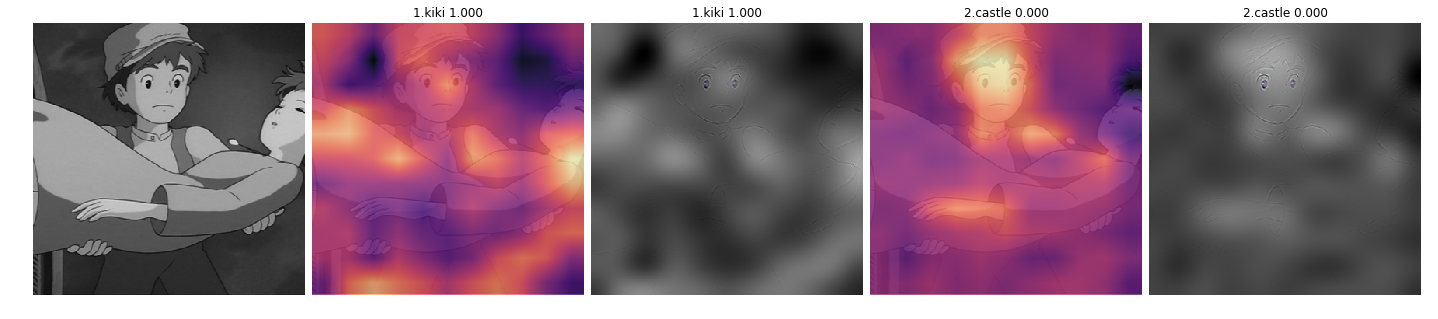

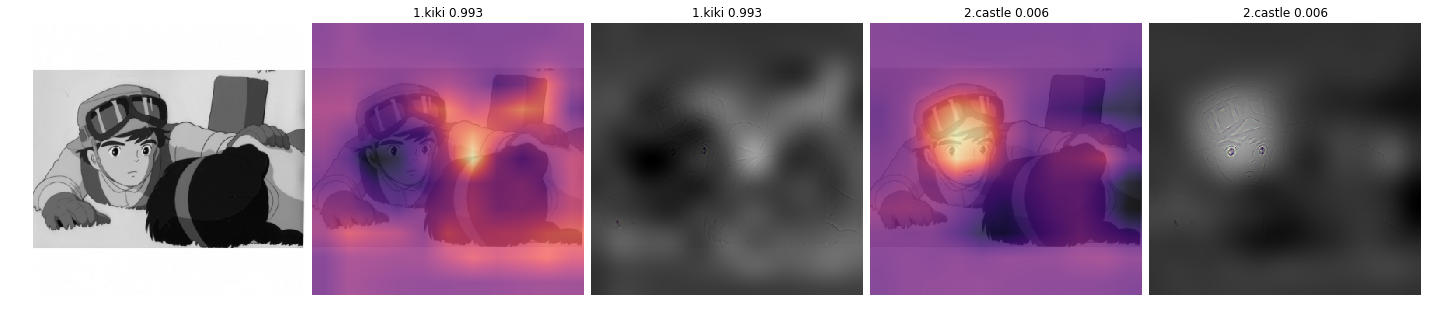

In [16]:
for idx in mismatch_idxs[:2]:
    gcam = GradCam.from_interp(learn,interp,idx,include_label=True)
    gcam.plot()

## Only plot predicted label

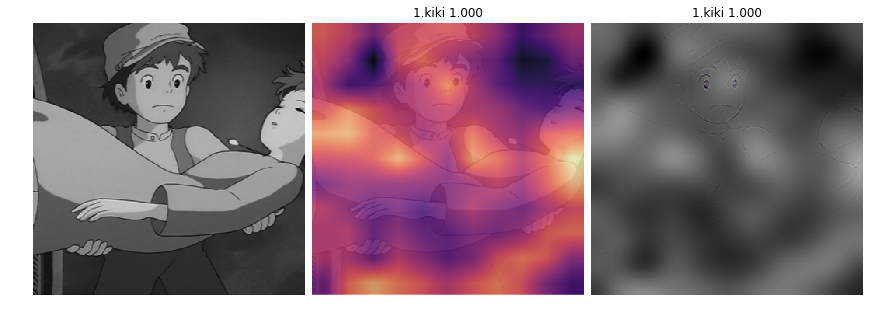

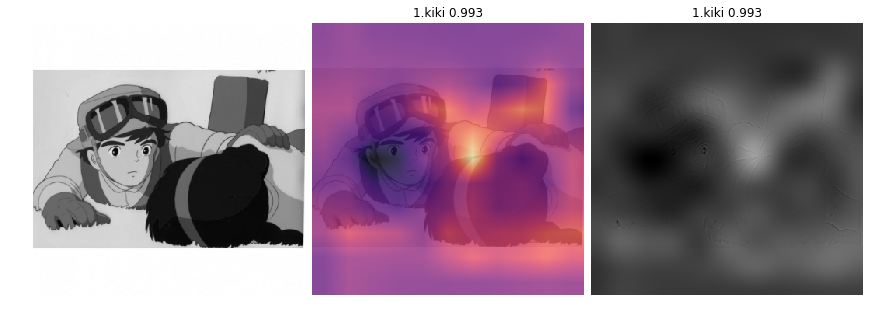

In [17]:
for idx in mismatch_idxs[:2]:
    gcam = GradCam.from_interp(learn,interp,idx,include_label=False)
    gcam.plot()

## From classification interpretation (Test set)

In [18]:
interp = ClassificationInterpretation.from_learner(learn,ds_type = DatasetType.Test)

interp.probs.shape

torch.Size([2, 10])

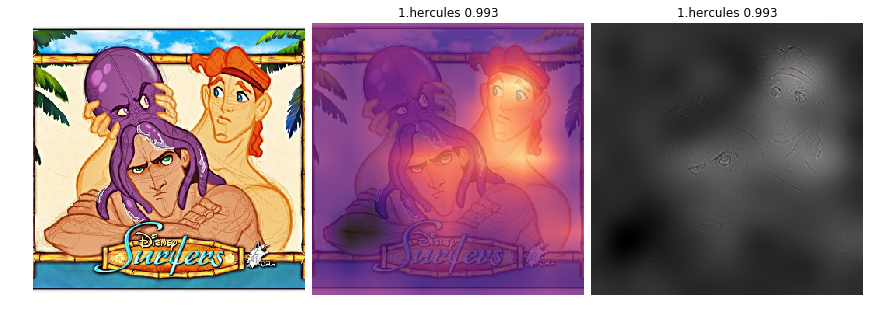

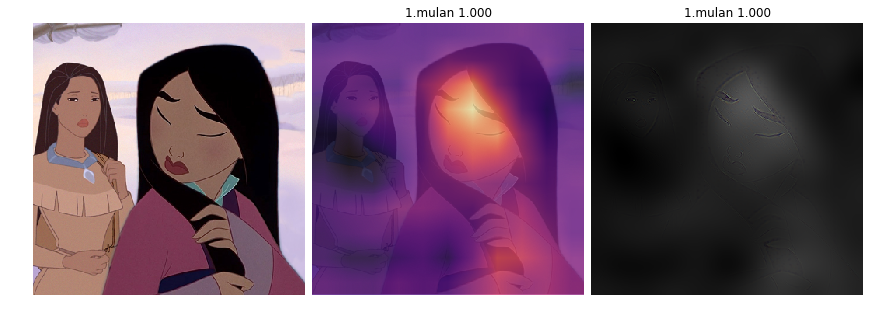

In [19]:
for idx in range(2):
    gcam = GradCam.from_interp(learn,interp,idx,ds_type = DatasetType.Test)
    gcam.plot()